<header style="padding:10px;background:#f9f9f9;border-top:3px solid #00b2b1"><img id="Teradata-logo" src="https://www.teradata.com/Teradata/Images/Rebrand/Teradata_logo-two_color.png" alt="Teradata" width="220" align="right" />

## Data Science Flow 101
</header>

<h3>Introduction</h3>
In this Jupyter Notebook, we will walk you through the standard flow of Data Science using the CRISP-DM standard (Cross-Industry Standard Process for Data Mining):

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/800px-CRISP-DM_Process_Diagram.png"  alt="CRISP-DM" style="width: 300px;"/>

You can find more information on <a href="https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining">Wikipedia</a> about this framework.

### 1. Business Understanding
The first step in CRISP-DM is the Business Understanding. Here, we want to better understand the impact of COVID-19 in Italy. To be precise, we would like to understand the maximum number of new daily cases that we will have in Italy. 

To forecast the number of cases, we will use the framework of Diffusion of Innovations where the number of people purchasing a new product (e.g. iPhone 11) or contracting a virus such as COVID-19 is proportional to the number of people who already have it (product or virus) and to the number of people left (word of mouth, comunity spreading) as well as extragenous factor which will be proportional to the number of people left.

(New People) = (some parameter) * (Number of People who already have it) * (Number of People left who don't have it) + (some other parameter) * (Number of People left who don't have it) 

dN = a * N * (NMAX - N) + b * (NMAX - N)

with dN = New People (new cases), N = Total People with it (cumulative cases), NMAX = Total people in the market who could have it, and a & b  some parameters that we need to model.

Transforming this function and you get a basic 2nd order polynomial, i.e. f(X) = A + B * x + C * x^2 with x = N

### 2. Data Understanding
There are many sources of data. Here, we will use the data from the European Centre for Disease Prevention and Control at https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide.

The current data in Excel is located at https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-2020-03-10.xls. 

We start by reading this remote data into a Pandas dataframe:

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_excel("https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-2020-03-10.xls")

Then we explore the data to better understand it. What is inside the dataframe?

In [3]:
df

,DateRep,CountryExp,NewConfCases,NewDeaths,GeoId,EU
0,2020-03-08,Afghanistan,3,0,AF,Non-EU/EEA
1,2020-03-02,Afghanistan,0,0,AF,Non-EU/EEA
2,2020-03-01,Afghanistan,0,0,AF,Non-EU/EEA
3,2020-02-29,Afghanistan,0,0,AF,Non-EU/EEA
4,2020-02-28,Afghanistan,0,0,AF,Non-EU/EEA
...,...,...,...,...,...,...
4647,2020-01-04,Vietnam,0,0,VN,Non-EU/EEA
4648,2020-01-03,Vietnam,0,0,VN,Non-EU/EEA
4649,2020-01-02,Vietnam,0,0,VN,Non-EU/EEA
4650,2020-01-01,Vietnam,0,0,VN,Non-EU/EEA


From this, we can guess/infer the following:

* DateRep is the date of the reported values
* CountryExp is the country 
* NewConfCases is the number of new cases for that day in that country
* NewDeaths is the number of new deaths for that day in that country
* GeoId and EU are metadata information related to the country

### 3. Data Preparation
Now that we understand what each columns and column's values mean, we can manipulate the dataframe to get
the analytics dataset that we will use for the modeling

Let's filter down to Italy. First we create a list of boolean to check if the row is for Italy:

In [4]:
df['CountryExp']=='Italy'

0       False
1       False
2       False
3       False
4       False
        ...  
4647    False
4648    False
4649    False
4650    False
4651    False
Name: CountryExp, Length: 4652, dtype: bool

Then we apply this list to the current dataframe:

In [5]:
df = df[df['CountryExp']=='Italy']

In [6]:
df

,DateRep,CountryExp,NewConfCases,NewDeaths,GeoId,EU
2285,2020-03-10,Italy,1797,98,IT,EU
2286,2020-03-09,Italy,1492,133,IT,EU
2287,2020-03-08,Italy,1247,36,IT,EU
2288,2020-03-07,Italy,778,49,IT,EU
2289,2020-03-06,Italy,769,41,IT,EU
...,...,...,...,...,...,...
2351,2020-01-04,Italy,0,0,IT,EU
2352,2020-01-03,Italy,0,0,IT,EU
2353,2020-01-02,Italy,0,0,IT,EU
2354,2020-01-01,Italy,0,0,IT,EU


We will now also remove all the zeros before the virus reached Italy with the same technique:

In [7]:
df = df[df['NewConfCases']>0]

In [8]:
df

,DateRep,CountryExp,NewConfCases,NewDeaths,GeoId,EU
2285,2020-03-10,Italy,1797,98,IT,EU
2286,2020-03-09,Italy,1492,133,IT,EU
2287,2020-03-08,Italy,1247,36,IT,EU
2288,2020-03-07,Italy,778,49,IT,EU
2289,2020-03-06,Italy,769,41,IT,EU
2290,2020-03-05,Italy,587,27,IT,EU
2291,2020-03-04,Italy,667,28,IT,EU
2292,2020-03-03,Italy,146,17,IT,EU
2293,2020-03-02,Italy,561,6,IT,EU
2294,2020-03-01,Italy,240,8,IT,EU


Let's order now by day:

In [9]:
df=df.sort_values(by=['DateRep'])

In [10]:
df

,DateRep,CountryExp,NewConfCases,NewDeaths,GeoId,EU
2324,2020-01-31,Italy,3,0,IT,EU
2302,2020-02-22,Italy,14,0,IT,EU
2301,2020-02-23,Italy,62,2,IT,EU
2300,2020-02-24,Italy,53,0,IT,EU
2299,2020-02-25,Italy,97,4,IT,EU
2298,2020-02-26,Italy,93,5,IT,EU
2297,2020-02-27,Italy,78,1,IT,EU
2296,2020-02-28,Italy,250,5,IT,EU
2295,2020-02-29,Italy,238,4,IT,EU
2294,2020-03-01,Italy,240,8,IT,EU


Let's add the cumulative number of cases and deaths with:

In [11]:
df["CumulConfCases"] = df["NewConfCases"].cumsum()
df["CumulDeaths"] = df["NewDeaths"].cumsum()

In [12]:
df

,DateRep,CountryExp,NewConfCases,NewDeaths,GeoId,EU,CumulConfCases,CumulDeaths
2324,2020-01-31,Italy,3,0,IT,EU,3,0
2302,2020-02-22,Italy,14,0,IT,EU,17,0
2301,2020-02-23,Italy,62,2,IT,EU,79,2
2300,2020-02-24,Italy,53,0,IT,EU,132,2
2299,2020-02-25,Italy,97,4,IT,EU,229,6
2298,2020-02-26,Italy,93,5,IT,EU,322,11
2297,2020-02-27,Italy,78,1,IT,EU,400,12
2296,2020-02-28,Italy,250,5,IT,EU,650,17
2295,2020-02-29,Italy,238,4,IT,EU,888,21
2294,2020-03-01,Italy,240,8,IT,EU,1128,29


Finally, we filter down the dataset to the columns of interest while renaming it dN and N:

In [13]:
df_cases = df.filter(items=['DateRep', 'NewConfCases','CumulConfCases']) \
    .rename(columns={"DateRep": "T", "NewConfCases": "dN", "CumulConfCases": "N"})
df_deaths = df.filter(items=['DateRep', 'NewDeaths','CumulDeaths']) \
    .rename(columns={"DateRep": "T", "NewDeaths": "dN", "CumulDeaths": "N"})

Finaly, we define the time series index of those two final datasets:

In [14]:
df_cases = df_cases.set_index('T')
df_deaths = df_deaths.set_index('T')

In [15]:
df_cases

,dN,N
T,,
2020-01-31,3,3
2020-02-22,14,17
2020-02-23,62,79
2020-02-24,53,132
2020-02-25,97,229
2020-02-26,93,322
2020-02-27,78,400
2020-02-28,250,650
2020-02-29,238,888


Let's do some charts. For this we need to load matplotlib and enable inline charts in Jupyter notebook.

In [16]:
# Import Matplotlib for charts
import matplotlib.pyplot as plt
%matplotlib inline

The time-series for N and dN:

<AxesSubplot:xlabel='T'>

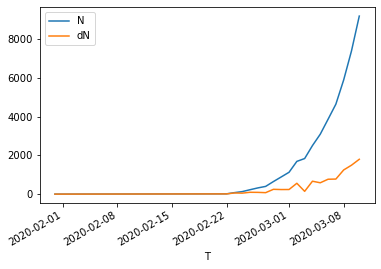

In [17]:
df_cases.plot(y=["N","dN"])

Let's plot the data in a scatter plot dN as function of N, as defined in our Diffusion of Innovation framework:

<AxesSubplot:xlabel='N', ylabel='dN'>

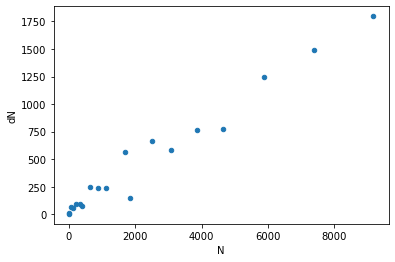

In [18]:
df_cases.plot.scatter(x='N',y='dN')

### 4. Modeling
We will use the package iMinuit which enables to fit any custom functions to a dataset.

In [19]:
!pip install --user iminuit

In [20]:
# Import Python wrapper on CERN's Minuit to fit a function using the Chi Square Minimalization approach
from iminuit import Minuit, describe
# Import NumPy to numeric computation
import numpy as np

As seen in the scatter chart above, there is no sign of the data trending. This means that there is no sensitivity to how big NMAX will ever be (i.e. the total number of people that will be eventually infected). 

To make a prediction, let's define this as 1% of Italy's population (1% of 60.5 million)

In [21]:
NMAX = 60.5e6 * 0.01

In [22]:
def fit(a, b):
    return a * (NMAX - df_cases['N']) + b * df_cases['N'] * (NMAX - df_cases['N'])

We define the error function (i.e. Chi Square) which return the sum of the error squared for each points:

In [23]:
def chisquare(a, b):    
    return (df_cases['dN'] - fit(a,b)).pow(2).sum()

For example, the total Chi Square error for a = 0.1 and b = 0.2 is

In [24]:
chisquare(0.1, 0.2)

3.3551355075123845e+18

We create now the minimization object m with Minuit to minimize the function `chisquare`

In [25]:
m = Minuit(chisquare, 0.1, 0.2)

We now execute the fit to find the best parameters describing the data:

In [26]:
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.663e+05                  │              Nfcn = 35               │
│ EDM = 1.15e-06 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  58.4e-6  │  0.5e-6   │            │            │         │         │       │
│ 1 │ b    │ 323.10e-9 │  0.14e-9  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         a         b │
├───┼─────────────────────┤
│ a │  2.54e-13 -4.79e-17 │
│ b │ -4.79e-17  2.09e-20 │
└───┴─────────────────────┘

### 5. Evaluation

Now that we have our model with parameters, we can check the robustness of our model. We can do this multiple way. 
In cases, we have a lot of data, we can use a test sample, or cross-validate with a different time range or market.

Here, with very limited number, we can do basic assessment of the error of our parameters.

We can start looking at this Chi Square function as function of the parameter `a` and identify the range in which we 
can trust its value (i.e. confidence interval).

(array([5.74130680e-05, 5.74826299e-05, 5.75521918e-05, 5.76217537e-05,
        5.76913155e-05, 5.77608774e-05, 5.78304393e-05, 5.79000012e-05,
        5.79695631e-05, 5.80391250e-05, 5.81086869e-05, 5.81782488e-05,
        5.82478107e-05, 5.83173726e-05, 5.83869345e-05, 5.84564964e-05,
        5.85260583e-05, 5.85956202e-05, 5.86651821e-05, 5.87347440e-05,
        5.88043059e-05, 5.88738677e-05, 5.89434296e-05, 5.90129915e-05,
        5.90825534e-05, 5.91521153e-05, 5.92216772e-05, 5.92912391e-05,
        5.93608010e-05, 5.94303629e-05]),
 array([166305.1182034 , 166304.5855341 , 166304.09091473, 166303.63434531,
        166303.21582582, 166302.83535628, 166302.49293668, 166302.18856701,
        166301.92224729, 166301.69397751, 166301.50375767, 166301.35158777,
        166301.23746781, 166301.16139779, 166301.12337771, 166301.12340757,
        166301.16148737, 166301.23761712, 166301.3517968 , 166301.50402642,
        166301.69430599, 166301.92263549, 166302.18901494, 166302.49344432

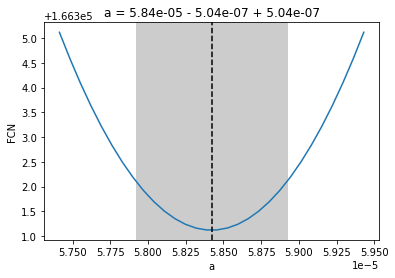

In [27]:
m.draw_mnprofile("a")

Ballpark, the best value from the data is 6.15e-7, but there is 68% chance that the value is between 6.1e-7 and 6.2e-7.

We can check now the parameter `b`:

(array([3.22806562e-07, 3.22826518e-07, 3.22846473e-07, 3.22866429e-07,
        3.22886384e-07, 3.22906340e-07, 3.22926295e-07, 3.22946251e-07,
        3.22966206e-07, 3.22986162e-07, 3.23006117e-07, 3.23026072e-07,
        3.23046028e-07, 3.23065983e-07, 3.23085939e-07, 3.23105894e-07,
        3.23125850e-07, 3.23145805e-07, 3.23165761e-07, 3.23185716e-07,
        3.23205672e-07, 3.23225627e-07, 3.23245582e-07, 3.23265538e-07,
        3.23285493e-07, 3.23305449e-07, 3.23325404e-07, 3.23345360e-07,
        3.23365315e-07, 3.23385271e-07]),
 array([166305.11569611, 166304.58319975, 166304.08875334, 166303.63235687,
        166303.21401034, 166302.83371375, 166302.4914671 , 166302.18727039,
        166301.92112362, 166301.69302679, 166301.50297991, 166301.35098296,
        166301.23703595, 166301.16113889, 166301.12329176, 166301.12349458,
        166301.16174733, 166301.23805003, 166301.35240267, 166301.50480524,
        166301.69525776, 166301.92376022, 166302.19031262, 166302.49491496

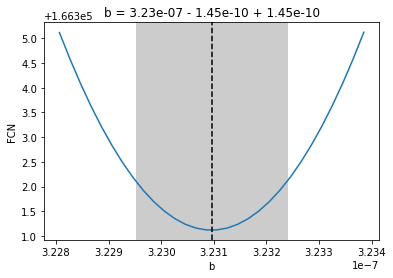

In [28]:
m.draw_mnprofile("b")

Here the best value is 3.1885E-9, but there is 68% chance that the value is between 3.187e-9 and 3.190e-9.

We can check the dependency between the two variables:

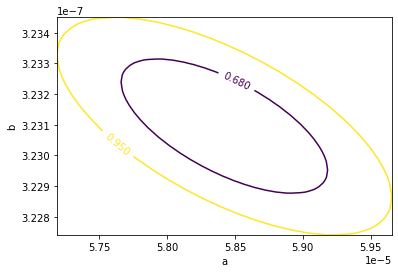

In [29]:
m.draw_mncontour("a","b", cl = [0.680, 0.950])

Here, the black ellipse represent the range we just identified at 68% confidence interval. The red ellipse is at 95% confidence interval.

Let's now apply those fitted value to see the result in a chart:

In [30]:
a=m.values["a"]
b=m.values["b"]

In [31]:
df_cases['fit'] = a * (NMAX - df_cases['N']) + b * df_cases['N'] * (NMAX - df_cases['N'])

<AxesSubplot:xlabel='N'>

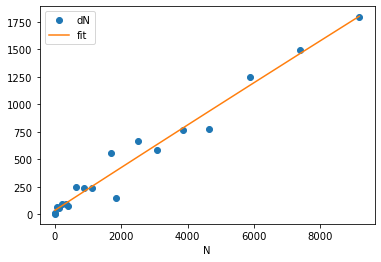

In [32]:
df_cases.plot('N',['dN','fit'],style=['o','-'])

### 6. Deployment
Deployment is about using the insights we found to do something differently. It can be a single event or a repetitive tasks. 

Let's start with the simpler case. For one off case such as here, we would just extrapolate the insights into the answer we are looking for: what is the maximum daily new cases we can have in Italy.

In [33]:
xx=np.arange(0,NMAX*0.55,NMAX/1000)

In [34]:
yy = a * (NMAX - xx) + b * xx * (NMAX - xx)

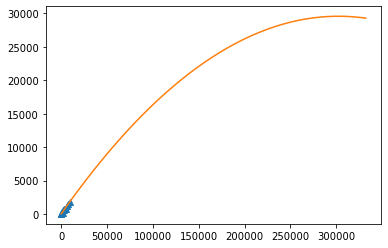

In [35]:
plt.plot(df_cases['N'], df_cases['dN'], '^', xx, yy, '-')

Assuming all our assumptions are correct (which they are likely not), this means that at the peak of the epidemic in Italy, we could see 30,000 new cases per day.

For repetitive tasks, we will need to automate the analysis and the deployment of the insights. 
So, we can start by developing one Python script with only the necessary steps, as well as input parameter to collect 
the relevant date of report, country, assumptiong, etc.

Here is an example of a covid19.py script:

```python
#!//usr/bin/python3
import sys
import pandas as pd
from iminuit import Minuit, describe
import numpy as np

# Get Report Date from command line
if len(sys.argv) != 3:
        print('Usage: covid19.py [date] [country]')
        sys.exit(1)
rep_date = sys.argv[1]
country = sys.argv[2]

# Import data locally
data_url = "https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-" + rep_date + ".xls"
df = pd.read_excel(data_url)

# Filter data
df = df[df['CountryExp']==country]
df = df[df['NewConfCases']>0]
df = df.sort_values(by=['DateRep'])
df["CumulConfCases"] = df["NewConfCases"].cumsum()
df["CumulDeaths"] = df["NewDeaths"].cumsum()
df = df.filter(items=['DateRep', 'NewConfCases','CumulConfCases']). \
    rename(columns={"DateRep": "T", "NewConfCases": "dN", "CumulConfCases": "N"}). \
    set_index('T')

# Prepare model fit
NMAX = 60.5e6 * 0.01
x = df['N']
y = df['dN']

def fit(a, b):
    return a * (NMAX - x) + b * x * (NMAX - x)
def chisquare(a, b):
    return (y - fit(a,b)).pow(2).sum()

# Execute the fit
m = Minuit(chisquare, print_level=0, pedantic=False)
m.migrad()
a=m.values["a"]
b=m.values["b"]
xx=np.arange(0,NMAX,NMAX/100)
yy = a * (NMAX - xx) + b * xx * (NMAX - xx)
print("Max:",max(yy))
```

Running ```./covid19.py 2020-03-10 Italy``` will give ```Max: 29582.958532824043```.

Whereas ```./covid19.py 2020-03-08 Italy``` will give ```Max: 29105.409956316485```.

With this script doing the work, we would need to deploy it on a production system, for example a Docker image in AppCenter, AWS EC2, or
other Google GCE. Then set up a scheduler to refresh the analysis, a monitoring to alert when there is an error, and finally 
integrate in the operation. What will you do with this data? Maybe here an automated email to the secretary of health in Italy with the forecast of the worst to come?

And you, what do you think? What would you do?

<footer style="padding:10px;background:#f9f9f9;border-bottom:3px solid #394851">©2020 Teradata. All Rights Reserved</footer>